In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import initializers
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Activation,Dropout,Flatten,LSTM,Input,BatchNormalization,Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K
import tensorflow.keras.metrics as metrics
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import pandas as pd
import random as rn

import os
import datetime


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/Deep Learning/LSTM Assignment"

In [4]:
!ls

gdrive	sample_data


In [5]:
%cd /content/gdrive/My Drive/Colab Notebooks/Deep Learning/LSTM Assignment

/content/gdrive/My Drive/Colab Notebooks/Deep Learning/LSTM Assignment


In [6]:
import sqlite3

con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 
filtered_data.head()

Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]

# Data Cleaning

In [7]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    #To remove repetetive words like aa bbb ccc 
    phrase = re.sub(r"(.)\1{2,}","", phrase)
    return phrase

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = re.sub(r"(.)\1{2,}","", sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:45<00:00, 1940.73it/s]


In [ ]:
# Combining all the above stundents 
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = re.sub(r"(.)\1{2,}","", sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

  6%|▌         | 21456/348260 [00:08<02:03, 2644.27it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 348260/348260 [02:15<00:00, 2577.24it/s]


In [ ]:
preprocessed_reviews_summary[500]

'best mole trap ever'

In [ ]:
preprocessed_reviews[500]

'female dog eats food not find burn spots lawn makes husband happy'

In [14]:
#final['Summary'] = preprocessed_reviews_summary
final['Text'] = preprocessed_reviews

In [ ]:
final.head(2)

Id  ...                                               Text
138702  150520  ...  book purchased birthday gift year old boy sque...
138707  150525  ...  daughter loves really rosie books introduced r...

[2 rows x 10 columns]

In [ ]:
final['Score'].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

Balancing negative and positive classes

In [15]:
# Choosing positive and negative reviews
df_pos=final[final.Score == 1]
df_neg=final[final.Score == 0]

# Reducing reviews to 50k each from each class
df_pos = df_pos.sample(n=9000, random_state=36)
df_neg = df_neg.sample(n=9000, random_state=36)

# Shuffling dataset
final = pd.concat([df_pos,df_neg], ignore_index=True)
final = final.sample(frac=1).reset_index(drop=True)
final['Score'].value_counts()

1    9000
0    9000
Name: Score, dtype: int64

# Tokenizing Data

In [16]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from collections import Counter
import seaborn as sns
import itertools
import collections
from collections import OrderedDict

In [17]:
X=np.array(final['Text'])
Y = np.array(final['Score'])

#Spliting Dataset to (Train-CrossValidation)70%,(Test)30%
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X, Y, test_size=0.3,random_state=36,stratify = Y)
#X_cv, X_test, Y_cv, Y_test = train_test_split(X_cv, Y_cv, test_size=0.3,random_state=0,stratify = Y_cv)

In [18]:
unique_elements, counts_elements = np.unique(Y_cv, return_counts=True)
print("Value counts of class labels in Train data set:")
print(np.asarray((unique_elements, counts_elements)))

Value counts of class labels in Train data set:
[[   0    1]
 [2700 2700]]


In [19]:
top_words = 5000

Tokenizing

In [20]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_tr)

X_tr2 = tokenize.texts_to_sequences(X_tr)
X_cv2 = tokenize.texts_to_sequences(X_cv)

***Custom*** **function** for Tokenizing

In [ ]:
X_tr2 = [x.split() for x in X_tr]
X_cv2 = [x.split() for x in X_cv]

In [ ]:
def getDictionaryOnTrainData(X):
  # List of all words in reviews
  list_words = list(itertools.chain(*X))
  # counter
  counts_words = collections.Counter(list_words).most_common()
  d = OrderedDict(counts_words) 
  res = {val : idx + 1 for idx, val in enumerate(d.keys())}

  return res

In [ ]:
wordsCountDict = getDictionaryOnTrainData(X_tr2)

In [ ]:
def wordsToFrequencyRanks(X,top_words,res):

  for i in tqdm(range(len(X))):  
    for j in range(len(X[i])):
        if X[i][j] in res.keys():
          X[i][j] = res[X[i][j]] if res[X[i][j]] < top_words+1 else top_words
        else:
          X[i][j] = top_words 
  return X

In [ ]:
X_tr2 = wordsToFrequencyRanks(X_tr2,top_words,wordsCountDict)
X_cv2 = wordsToFrequencyRanks(X_cv2,top_words,wordsCountDict)


100%|██████████| 42000/42000 [00:01<00:00, 41090.55it/s]

100%|██████████| 18000/18000 [00:00<00:00, 42108.76it/s]


Padding

In [22]:
# truncate and/or pad input sequences
max_review_length = 360
embedding_vecor_length = 32
X_train = sequence.pad_sequences(X_tr2, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_cv2, maxlen=max_review_length)


(12600, 360)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [102]:
print(X_train.shape)
print(X_train[1])

(12600, 360)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

# 1 LSTM Layer

In [ ]:
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,kernel_initializer='glorot_uniform'))
model.add(Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 360, 32)           160032    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, Y_tr, epochs=5, batch_size=128, validation_data=(X_test, Y_cv))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14000 samples, validate on 6000 samples
Epoch 1/5
14000/14000 [==============================] - 89s 6ms/step - loss: 0.5565 - accuracy: 0.7254 - val_loss: 0.4105 - val_accuracy: 0.8080
Epoch 2/5
14000/14000 [==============================] - 89s 6ms/step - loss: 0.3195 - accuracy: 0.8690 - val_loss: 0.3185 - val_accuracy: 0.8630
Epoch 3/5
14000/14000 [==============================] - 93s 7ms/step - loss: 0.2397 - accuracy: 0.9060 - val_loss: 0.3264 - val_accuracy: 0.8647
Epoch 4/5
14000/14000 [==============================] - 92s 7ms/step - loss: 0.1995 - accuracy: 0.9244 - val_loss: 0.3368 - val_accuracy: 0.8647
Epoch 5/5
14000/14000 [==============================] - 89s 6ms/step - loss: 0.1670 - accuracy: 0.9355 - val_loss: 0.3679 - val_accuracy: 0.8633


In [ ]:
def plt_dynamic(epochs, vy, ty):
    fig,ax = plt.subplots(1,1,figsize=(20,12))
    ax.set_xlabel('epoch',fontsize=18) ; ax.set_ylabel('Binary Crossentropy Loss',fontsize=18)
    x = list(range(1,epochs+1))
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    legend = ax.legend(loc='center', shadow=True, fontsize='x-large')
    plt.show

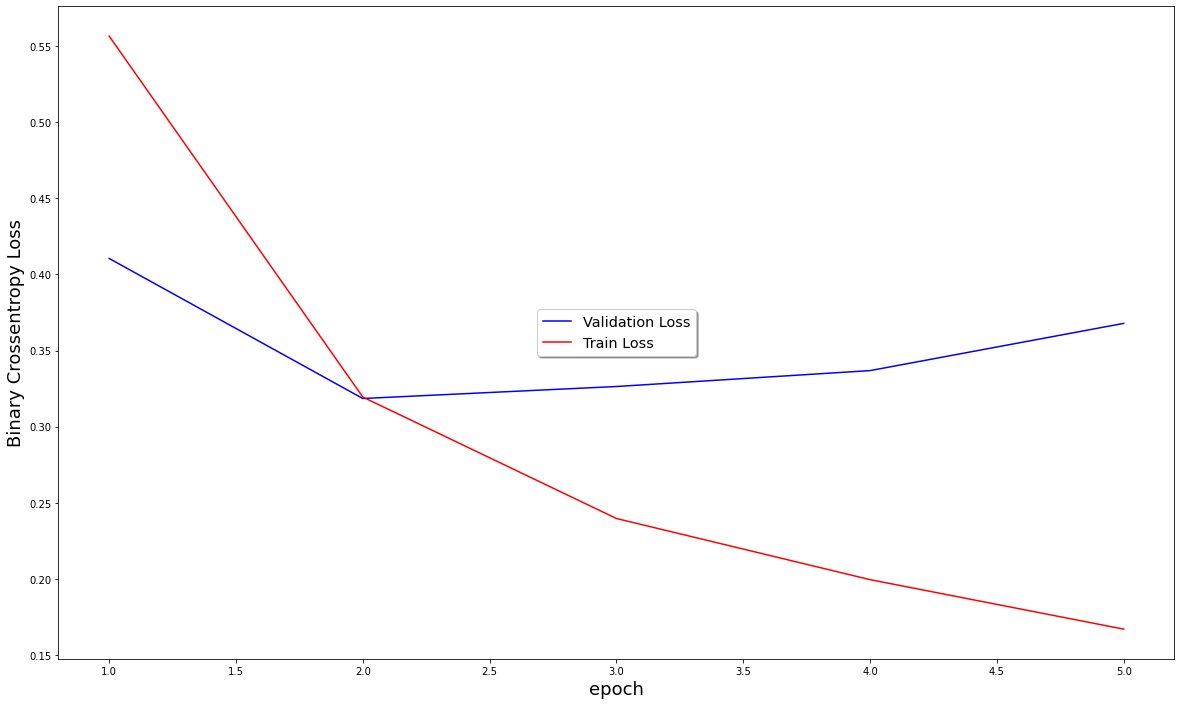

In [ ]:
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(5, vy, ty)

# 2 LSTM Layers


In [ ]:
embedding_vecor_length = 32
model2 = Sequential()
model2.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model2.add(LSTM(100,return_sequences=True,dropout=0.3))
model2.add(LSTM(100))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
print(model2.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 360, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 360, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history2 = model2.fit(X_train, Y_tr, epochs=5, batch_size=128, validation_data=(X_test, Y_cv))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70000 samples, validate on 30000 samples
Epoch 1/5
70000/70000 [==============================] - 1359s 19ms/step - loss: 0.3492 - accuracy: 0.8450 - val_loss: 0.2781 - val_accuracy: 0.8857
Epoch 2/5
70000/70000 [==============================] - 1500s 21ms/step - loss: 0.2666 - accuracy: 0.8915 - val_loss: 0.2750 - val_accuracy: 0.8870
Epoch 3/5
70000/70000 [==============================] - 1455s 21ms/step - loss: 0.2426 - accuracy: 0.9018 - val_loss: 0.2768 - val_accuracy: 0.8889
Epoch 4/5
70000/70000 [==============================] - 1355s 19ms/step - loss: 0.2260 - accuracy: 0.9100 - val_loss: 0.2731 - val_accuracy: 0.8876
Epoch 5/5
70000/70000 [==============================] - 1398s 20ms/step - loss: 0.2125 - accuracy: 0.9170 - val_loss: 0.2760 - val_accuracy: 0.8888


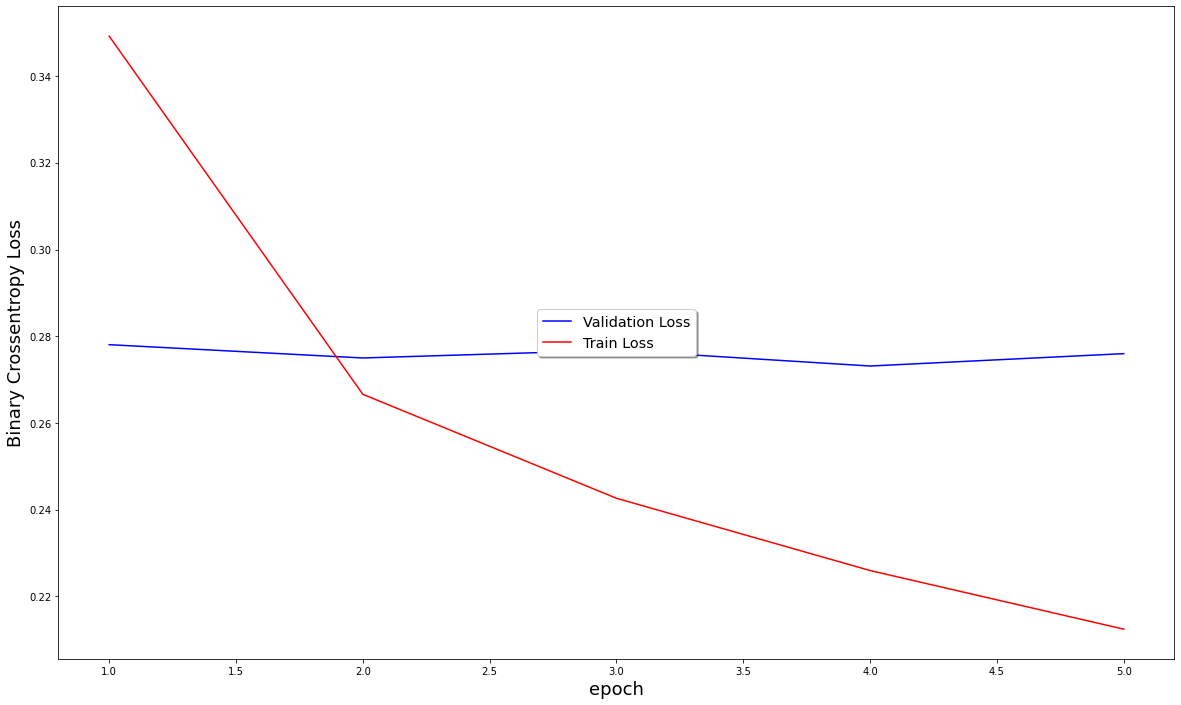

In [ ]:
vy2 = history2.history['val_loss']
ty2 = history2.history['loss']
plt_dynamic(5, vy2, ty2)

# Summary

In [ ]:
accuracy_1 = float(history.history['val_accuracy'].pop())
accuracy_2 = float(history2.history['val_accuracy'].pop())
loss_1 = float(history.history['val_loss'].pop())
loss_2 = float(history2.history['val_loss'].pop())

In [ ]:
from prettytable import PrettyTable    
Table = PrettyTable()
Table.field_names = ["LSTM Layers", "Test Accuracy","Test Loss"]
Table.add_row(["1",round(accuracy_1,4),round(loss_1,5)])
Table.add_row(["2",round(accuracy_2,4),round(loss_2,5)])
print(Table)

+-------------+---------------+-----------+
| LSTM Layers | Test Accuracy | Test Loss |
+-------------+---------------+-----------+
|      1      |     0.8821    |  0.31534  |
|      2      |     0.8888    |  0.27599  |
+-------------+---------------+-----------+


*   Model starts to Overfit after 2 epochs.
*   Computation time for training the 2 Layers LSTM Model was more
*   2 Layer LSTM Model performed slightly better than 1 Layer LSTM.


Sample Prediction



*   Using Keras Tokenizer



In [ ]:
example = [['healthy','nice','tasty','delicious'],
           ['worst','tasteless','unhealthy','bad'],
           ['lol','ball','call','hall']]
example = tokenize.texts_to_sequences(example)
example = sequence.pad_sequences(example, maxlen=max_review_length)

In [ ]:
result = model2.predict(example)
print('Positive Words example:',result[0])
print('Negative Words example:',result[1])
print('Random Words example:',result[2])

Positive Words example: [0.99772984]
Negative Words example: [0.00470731]
Random Words example: [0.40859026]




*   Using Custom tokenizer



In [ ]:
example = [['healthy','nice','tasty','delicious'],
           ['worst','tasteless','unhealthy','bad'],
           ['lol','ball','call','hall']]
example = wordsToFrequencyRanks(example,top_words,wordsCountDict)
example = sequence.pad_sequences(example, maxlen=max_review_length)

100%|██████████| 3/3 [00:00<00:00, 1238.72it/s]


In [ ]:
result = model2.predict(example)
print('Positive Words example:',result[0])
print('Negative Words example:',result[1])
print('Random Words example:',result[2])

Positive Words example: [0.99772984]
Negative Words example: [0.00470731]
Random Words example: [0.5038447]


# Understanding the LSTM Performance

https://udibhaskar.github.io/practical-ml/debugging%20nn/neural%20network/overfit/underfit/2020/02/03/Effective_Training_and_Debugging_of_a_Neural_Networks.html

In [23]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
wtrain = tf.summary.create_file_writer(logdir)
wval = tf.summary.create_file_writer(logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,kernel_initializer='glorot_uniform'))
model.add(Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 360, 32)           160032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, Y_tr, epochs=5, batch_size=128, validation_data=(X_test, Y_cv),callbacks=[tensorboard_callback])

Epoch 1/5
110/110 [==============================] - 93s 846ms/step - loss: 0.5263 - accuracy: 0.7093 - val_loss: 0.3772 - val_accuracy: 0.8365
Epoch 2/5
110/110 [==============================] - 90s 822ms/step - loss: 0.2784 - accuracy: 0.8891 - val_loss: 0.3367 - val_accuracy: 0.8560
Epoch 3/5
110/110 [==============================] - 90s 822ms/step - loss: 0.2629 - accuracy: 0.8998 - val_loss: 0.3732 - val_accuracy: 0.8535
Epoch 4/5
110/110 [==============================] - 89s 812ms/step - loss: 0.1950 - accuracy: 0.9278 - val_loss: 0.3795 - val_accuracy: 0.8570
Epoch 5/5
110/110 [==============================] - 89s 812ms/step - loss: 0.1648 - accuracy: 0.9432 - val_loss: 0.3947 - val_accuracy: 0.8520


In [24]:
%load_ext tensorboard

In [87]:
%tensorboard --logdir logs/gradient/

Reusing TensorBoard on port 6009 (pid 2225), started 0:12:30 ago. (Use '!kill 2225' to kill it.)

<IPython.core.display.Javascript object>

In [103]:
logdir = os.path.join("logs/gradient", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
train_log_dir = logdir + '/train'
test_log_dir = logdir + '/test'
wtrain = tf.summary.create_file_writer(train_log_dir)
wval = tf.summary.create_file_writer(test_log_dir)

In [104]:
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)


##model
def get_model():
    input_layer = Input(shape=(max_review_length,), name="input_layer")
    ##i am initilizing randomly. But you can use predefined embeddings. 
    x_embedd = Embedding(input_dim=top_words+1, output_dim=embedding_vecor_length, input_length=max_review_length, mask_zero=True, 
                        embeddings_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23),
                         name="Embedding_layer")(input_layer)
    
    x_lstm = LSTM(units=20, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
                 kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26),
                 recurrent_initializer=tf.keras.initializers.orthogonal(seed=54),
                 bias_initializer=tf.keras.initializers.zeros(), name="LSTM_layer")(x_embedd)
    
    x_out = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),
                  name="output_layer")(x_lstm)
    
    basic_lstm_model = Model(inputs=input_layer, outputs=x_out, name="basic_lstm_model")
    
    return basic_lstm_model


basic_lstm_model = get_model()
basic_lstm_model_anothertest = get_model()

In [97]:
def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [98]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='auto')

In [105]:
basic_lstm_model = get_model()

##optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

##metric
from sklearn.metrics import roc_auc_score

##train step function to train
@tf.function
def train_step(input_vector, output_vector,loss_fn):
    with tf.GradientTape() as tape:
        #forward propagation
        output_predicted = basic_lstm_model(inputs=input_vector, training=True)
        #loss
        loss = loss_fn(output_vector, output_predicted)
    #getting gradients
    gradients = tape.gradient(loss, basic_lstm_model.trainable_variables)
    gradients = [tf.clip_by_norm(g, 0.3)
             for g in gradients]
    #applying gradients
    optimizer.apply_gradients(zip(gradients, basic_lstm_model.trainable_variables))
    return loss, output_predicted, gradients

##validation step function
@tf.function
def val_step(input_vector, output_vector, loss_fn):
    #getting output of validation data
    output_predicted = basic_lstm_model(inputs=input_vector, training=False)
    #loss calculation
    loss = loss_fn(output_vector, output_predicted)
    return loss, output_predicted

import math

#batch size
BATCH_SIZE=32
##number of epochs
EPOCHS=6

##metrics # Even if you use .fit method, it alsocalculates batchwise loss/metric and aggregates those.  
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
train_metric = tf.keras.metrics.Mean(name="train_auc")
val_metric = tf.keras.metrics.Mean(name="val_metric")

#tensorboard file writers
# wtrain = tf.summary.create_file_writer(logdir)
# wval = tf.summary.create_file_writer(logdir)


#no of data points/batch_size i.e number of iterations in the one epoch
iters = math.ceil(100/BATCH_SIZE) 


In [106]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_tr))
train_dataset = train_dataset.shuffle(12600).batch(32, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_cv))
val_dataset = val_dataset.batch(32, drop_remainder=True)

In [107]:
#training anf validating
for epoch in range(EPOCHS):
    
    #resetting the states of the loss and metrics
    train_loss.reset_states()
    val_loss.reset_states()
    train_metric.reset_states()
    val_metric.reset_states()
    
    ##counter for train loop iteration
    counter = 0
    
    #lists to save true and validation data. 
    train_true = []
    train_predicted = []
    val_true = []
    val_predicted = []
    
    #ietrating over train data batch by batch
    for text_seq, label_seq in train_dataset:
        #train step
        loss_, pred_out, gradients = train_step(text_seq, label_seq, loss_function)
        #adding loss to train loss
        train_loss(loss_)
        #counting the step number
        temp_step = epoch*iters+counter
        counter = counter + 1
        
        #calculating AUC for batch
        batch_metric = roc_auc_score(label_seq, pred_out)
        train_metric(batch_metric)
        
        #appending it to list
        train_predicted.append(pred_out)
        train_true.append(label_seq)
        
        ##tensorboard 
        with tf.name_scope('per_step_training'):
            with wtrain.as_default():
                tf.summary.scalar("batch_loss", loss_, step=temp_step)
                tf.summary.scalar('batch_metric', batch_metric, step=temp_step)
        with tf.name_scope("per_batch_gradients"):
            with wtrain.as_default():
                for i in range(len(basic_lstm_model.trainable_variables)):
                    name_temp = basic_lstm_model.trainable_variables[i].name
                    tf.summary.histogram(name_temp, gradients[i], step=temp_step)
    
    #calculating the final loss and metric
    train_true = tf.concat(train_true, axis=0)
    train_predicted = tf.concat(train_predicted, axis=0)
    train_loss_final = loss_function(train_true, train_predicted)
    train_metric_auc = roc_auc_score(train_true, train_predicted)
    
    #validation data
    for text_seq_val, label_seq_val in val_dataset:
        #getting val output
        loss_val, pred_out_val = val_step(text_seq_val, label_seq_val, loss_function)
        #appending to lists
        val_true.append(label_seq_val)
        val_predicted.append(pred_out_val)
        val_loss(loss_val)
        
        #calculating metric
        batch_metric_val = roc_auc_score(label_seq_val, pred_out_val)
        val_metric(batch_metric_val)
    
    
    #calculating final loss and metric   
    val_true = tf.concat(val_true, axis=0)
    val_predicted = tf.concat(val_predicted, axis=0)
    val_loss_final = loss_function(val_true, val_predicted)
    val_metric_auc = roc_auc_score(val_true, val_predicted)
    
    #printing
    template = '''Epoch {}, Train Loss: {:0.6f}, Mean batch Train Loss: {:0.6f}, AUC: {:0.5f}, Mean batch Train AUC: {:0.5f},
    Val Loss: {:0.6f}, Mean batch Val Loss: {:0.6f}, Val AUC: {:0.5f}, Mean batch Val AUC: {:0.5f}'''
    
    print(template.format(epoch+1, train_loss_final.numpy(), train_loss.result(), 
                          train_metric_auc, train_metric.result(), val_loss_final.numpy(),
                          val_loss.result(), val_metric_auc, val_metric.result()))
    print('-'*30)
    
    #tensorboard
    with tf.name_scope("per_epoch_loss_metric"):
        with wtrain.as_default():
            tf.summary.scalar("mean_loss", train_loss.result().numpy(), step=epoch)
            tf.summary.scalar('loss', train_loss_final.numpy(), step=epoch)
            tf.summary.scalar('metric', train_metric_auc, step=epoch)
            tf.summary.scalar('mean_metric', train_metric.result().numpy(), step=epoch)
        with wval.as_default():
            tf.summary.scalar('mean_loss', val_loss.result().numpy(), step=epoch)
            tf.summary.scalar('loss', val_loss_final.numpy(), step=epoch)
            tf.summary.scalar('metric', val_metric_auc, step=epoch)
            tf.summary.scalar('mean_metric', val_metric.result().numpy(), step=epoch)

Epoch 1, Train Loss: 0.643953, Mean batch Train Loss: 0.643952, AUC: 0.68010, Mean batch Train AUC: 0.67670,
    Val Loss: 0.584744, Mean batch Val Loss: 0.584745, Val AUC: 0.75964, Mean batch Val AUC: 0.75913
------------------------------
Epoch 2, Train Loss: 0.526575, Mean batch Train Loss: 0.526575, AUC: 0.81731, Mean batch Train AUC: 0.81873,
    Val Loss: 0.509893, Mean batch Val Loss: 0.509892, Val AUC: 0.83026, Mean batch Val AUC: 0.83020
------------------------------
Epoch 3, Train Loss: 0.446137, Mean batch Train Loss: 0.446137, AUC: 0.87506, Mean batch Train AUC: 0.87775,
    Val Loss: 0.462180, Mean batch Val Loss: 0.462180, Val AUC: 0.86367, Mean batch Val AUC: 0.86255
------------------------------
Epoch 4, Train Loss: 0.387729, Mean batch Train Loss: 0.387730, AUC: 0.90740, Mean batch Train AUC: 0.90943,
    Val Loss: 0.437234, Mean batch Val Loss: 0.437234, Val AUC: 0.87949, Mean batch Val AUC: 0.87863
------------------------------
Epoch 5, Train Loss: 0.347924, Mean 

In [ ]:
Play with LearningRate,GradientClipValue,Initializers